In [13]:
import pandas as pd
import numpy as np

def load_libsvm_with_concentration(path):
    """
    Loads gas sensor dataset in modified libsvm-like format:
    label;concentration f1:v1 f2:v2 ... f128:v128
    Returns: X (features), y (labels), conc (concentration levels)
    """
    y = []
    conc = []
    features = []
    
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            
            # First part is like "1;10.000000"
            label, conc_val = parts[0].split(";")
            y.append(int(label))
            conc.append(float(conc_val))
            
            # The rest are feature:value pairs
            feat_vals = [float(p.split(":")[1]) for p in parts[1:]]
            features.append(feat_vals)
    
    X = np.array(features)
    y = np.array(y)
    conc = np.array(conc)
    return X, y, conc

# Example usage: load Batch 1
X, y, conc = load_libsvm_with_concentration("Projects/Gas-Sensor-Classification/data/raw/batch1.dat")
print("X shape:", X.shape)   # (#samples, 128)
print("y shape:", y.shape, "unique labels:", np.unique(y))
print("Concentration shape:", conc.shape, "unique conc levels:", np.unique(conc)[:10])


X shape: (445, 128)
y shape: (445,) unique labels: [1 2 3 4 5 6]
Concentration shape: (445,) unique conc levels: [ 5. 10. 15. 20. 25. 30. 35. 40. 45. 50.]


In [17]:
import glob, os

all_X, all_y, all_conc = [], [], []

for path in sorted(glob.glob("Projects/Gas-Sensor-Classification/data/raw/batch*.dat")):
    Xb, yb, cb = load_libsvm_with_concentration(path)
    all_X.append(Xb)
    all_y.append(yb)
    all_conc.append(cb)

X = np.vstack(all_X)
y = np.concatenate(all_y)
conc = np.concatenate(all_conc)

print("Final dataset:", X.shape, y.shape, conc.shape)
print("Class distribution:", np.unique(y, return_counts=True))


Final dataset: (13910, 128) (13910,) (13910,)
Class distribution: (array([1, 2, 3, 4, 5, 6]), array([2565, 2926, 1641, 1936, 3009, 1833], dtype=int64))


In [19]:
from sklearn.model_selection import train_test_split

RNG = 42

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, random_state=RNG, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=RNG, stratify=y_tmp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (9737, 128) Val: (2086, 128) Test: (2087, 128)



Logistic Regression Validation Results
              precision    recall  f1-score   support

           1       0.99      0.98      0.99       384
           2       1.00      0.99      0.99       439
           3       0.99      0.98      0.98       246
           4       0.97      1.00      0.98       291
           5       0.98      0.99      0.99       451
           6       1.00      1.00      1.00       275

    accuracy                           0.99      2086
   macro avg       0.99      0.99      0.99      2086
weighted avg       0.99      0.99      0.99      2086



C:\Users\harsh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


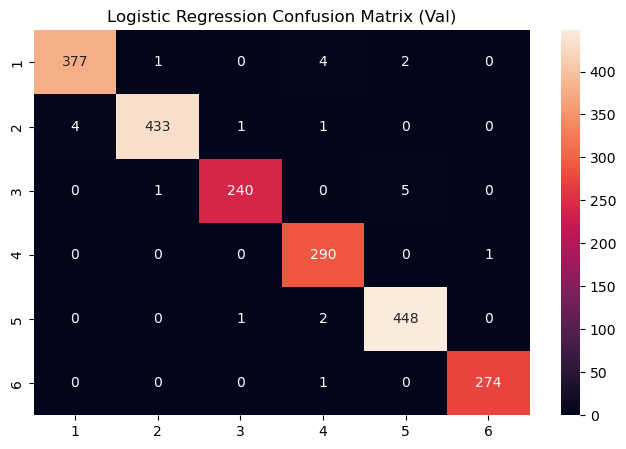


Random Forest Validation Results
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       384
           2       1.00      1.00      1.00       439
           3       0.99      0.98      0.99       246
           4       1.00      1.00      1.00       291
           5       0.99      1.00      0.99       451
           6       0.99      1.00      0.99       275

    accuracy                           0.99      2086
   macro avg       0.99      0.99      0.99      2086
weighted avg       0.99      0.99      0.99      2086



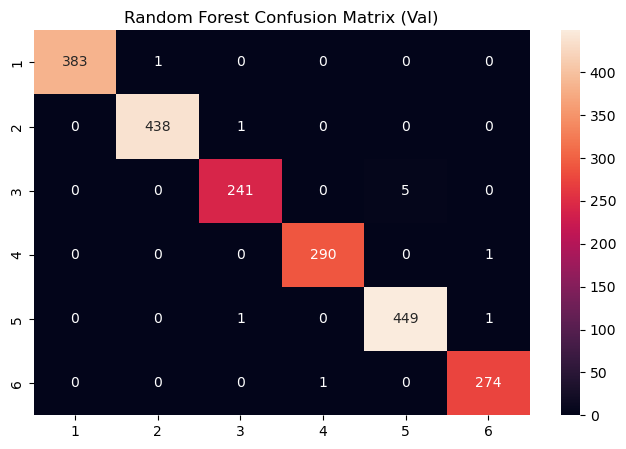


SVM RBF Validation Results
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       384
           2       0.99      1.00      0.99       439
           3       0.98      0.97      0.98       246
           4       1.00      0.99      0.99       291
           5       0.98      0.99      0.99       451
           6       0.99      1.00      0.99       275

    accuracy                           0.99      2086
   macro avg       0.99      0.99      0.99      2086
weighted avg       0.99      0.99      0.99      2086



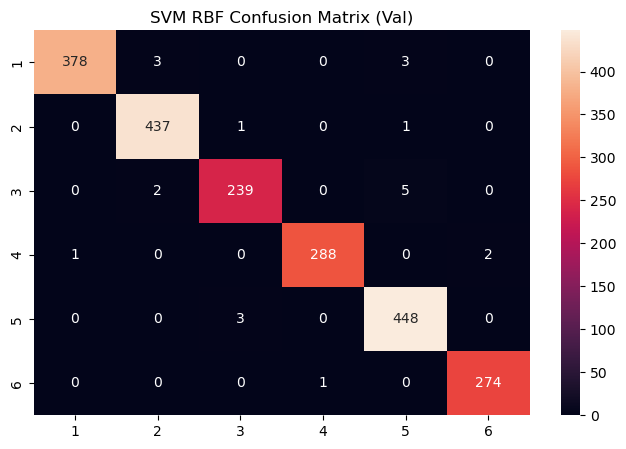

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def train_eval(pipe, name):
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)
    print(f"\n{name} Validation Results")
    print(classification_report(y_val, preds))
    cm = confusion_matrix(y_val, preds, labels=np.unique(y))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"{name} Confusion Matrix (Val)")
    plt.show()
    return pipe

lr = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=400))])
rf = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(n_estimators=300, random_state=RNG))])
svm = Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf", C=3, gamma="scale", probability=True))])

lr_model = train_eval(lr, "Logistic Regression")
rf_model = train_eval(rf, "Random Forest")
svm_model = train_eval(svm, "SVM RBF")


Test Results
              precision    recall  f1-score   support

           1       1.00      0.99      0.99       385
           2       0.99      1.00      0.99       439
           3       1.00      0.99      0.99       246
           4       0.99      0.99      0.99       290
           5       1.00      0.99      0.99       452
           6       0.99      0.99      0.99       275

    accuracy                           0.99      2087
   macro avg       0.99      0.99      0.99      2087
weighted avg       0.99      0.99      0.99      2087



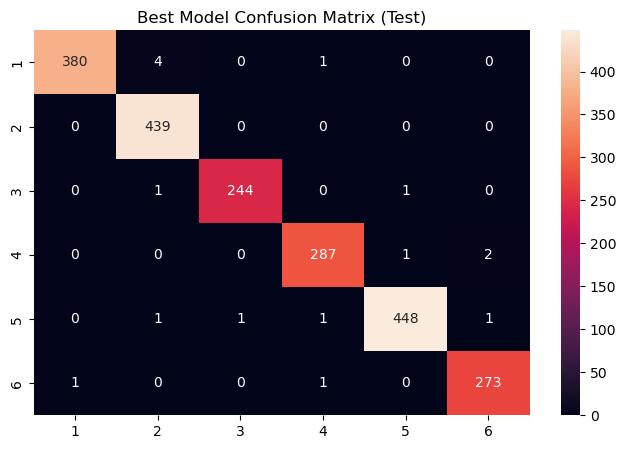

In [23]:
best_model = rf_model   # choose based on validation results
preds = best_model.predict(X_test)

print("Test Results")
print(classification_report(y_test, preds))
cm = confusion_matrix(y_test, preds, labels=np.unique(y))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Best Model Confusion Matrix (Test)")
plt.show()


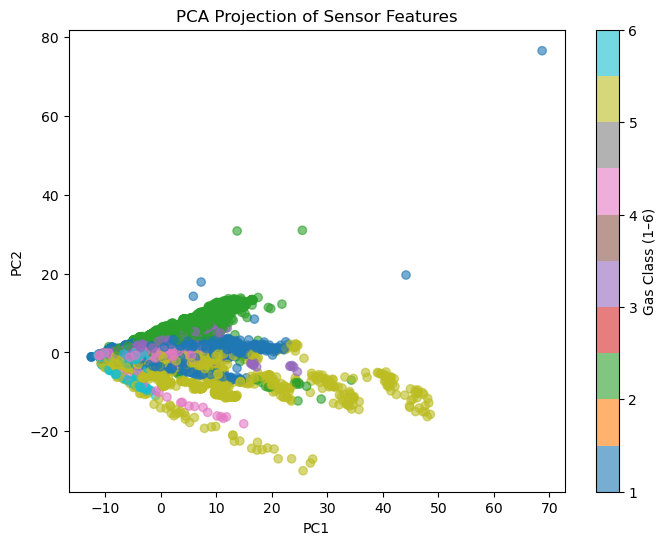

In [25]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
Xp = scaler.fit_transform(X_train)
pca = PCA(n_components=2)
Z = pca.fit_transform(Xp)

plt.figure(figsize=(8,6))
plt.scatter(Z[:,0], Z[:,1], c=y_train, cmap="tab10", alpha=0.6)
plt.colorbar(label="Gas Class (1–6)")
plt.title("PCA Projection of Sensor Features")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


In [27]:
# Use same features as classification
X_reg = X
y_reg = conc

print("X_reg shape:", X_reg.shape)
print("y_reg stats:", pd.Series(y_reg).describe())


X_reg shape: (13910, 128)
y_reg stats: count    13910.000000
mean       157.094644
std        171.443975
min          1.000000
25%         50.000000
50%        100.000000
75%        200.000000
max       1000.000000
dtype: float64


In [29]:
from sklearn.model_selection import train_test_split

RNG = 42

X_train_reg, X_tmp_reg, y_train_reg, y_tmp_reg = train_test_split(
    X_reg, y_reg, test_size=0.30, random_state=RNG
)
X_val_reg, X_test_reg, y_val_reg, y_test_reg = train_test_split(
    X_tmp_reg, y_tmp_reg, test_size=0.50, random_state=RNG
)

X_train_reg.shape, X_val_reg.shape, X_test_reg.shape


((9737, 128), (2086, 128), (2087, 128))

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

def eval_regressor(model, X_train, y_train, X_val, y_val, name="Model"):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    rmse = mean_squared_error(y_val, preds, squared=False)
    r2 = r2_score(y_val, preds)
    print(f"\n{name} Validation Results")
    print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")
    return model, preds

# Models
lin_reg = Pipeline([("scaler", StandardScaler()), ("clf", LinearRegression())])
rf_reg = RandomForestRegressor(n_estimators=300, random_state=RNG)
svr_reg = Pipeline([("scaler", StandardScaler()), ("clf", SVR(kernel="rbf", C=10, gamma="scale"))])

lin_model, _ = eval_regressor(lin_reg, X_train_reg, y_train_reg, X_val_reg, y_val_reg, "Linear Regression")
rf_model, _ = eval_regressor(rf_reg, X_train_reg, y_train_reg, X_val_reg, y_val_reg, "Random Forest Regressor")
svr_model, _ = eval_regressor(svr_reg, X_train_reg, y_train_reg, X_val_reg, y_val_reg, "SVR (RBF)")



Linear Regression Validation Results
MAE: 27.362, RMSE: 78.135, R²: 0.796

Random Forest Regressor Validation Results
MAE: 7.759, RMSE: 24.859, R²: 0.979

SVR (RBF) Validation Results
MAE: 25.678, RMSE: 58.644, R²: 0.885


In [33]:
best_reg = rf_model  

preds_test = best_reg.predict(X_test_reg)
mae = mean_absolute_error(y_test_reg, preds_test)
rmse = mean_squared_error(y_test_reg, preds_test, squared=False)
r2 = r2_score(y_test_reg, preds_test)

print("\nTest Set Results")
print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")



Test Set Results
MAE: 8.951, RMSE: 34.835, R²: 0.957


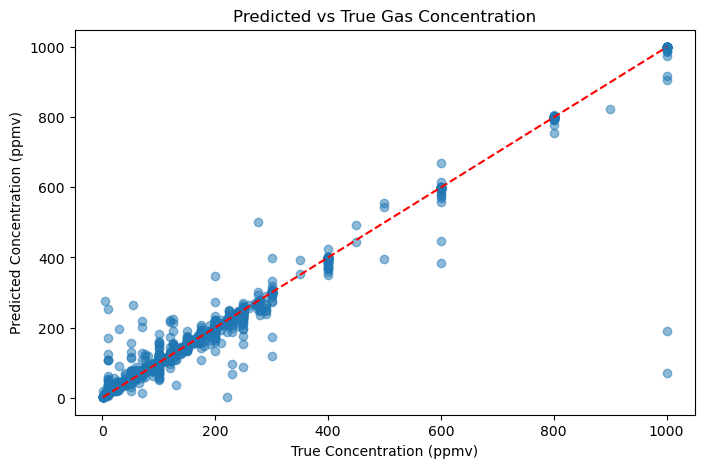

In [35]:
import matplotlib.pyplot as plt

plt.scatter(y_test_reg, preds_test, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.xlabel("True Concentration (ppmv)")
plt.ylabel("Predicted Concentration (ppmv)")
plt.title("Predicted vs True Gas Concentration")
plt.show()
